In [1]:
import torch
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

import os
from time import time

In [2]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!pip install gdown

### Get the data

In [4]:
import gdown
url = 'https://drive.google.com/uc?id=10f1H2T-5W-BiqabHHtlZ4ASs19TZmg8R'
output = 'data.zip'
gdown.download(url, output, quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=10f1H2T-5W-BiqabHHtlZ4ASs19TZmg8R

but Gdown can't. Please check connections and permissions.

Когда у меня кончилось время гпу на 1 из аккаунтов, я решил перейти на другой и мне выдало это, решил просто скачать зипку датасета и залить вручную в колаб

In [6]:
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0098_51410.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0115_51891.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0106_52729.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0056_51523.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0113_51525.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0009_51301.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0117_51363.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0104_52614.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0108_51108.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_0029_52613.jpg  
  inflating: data/train/images/064.Ring_billed_Gull/Ring_Billed_Gull_011

### Utilities (0.5 point)

Complete dataset to load prepared images and masks. Don't forget to use augmentations.

Some of the images are 1 channels, so use `gray2rgb`.

In [109]:
from typing import Optional, Callable
def gray2rgb(img):
    if len(img.shape) != 3:
        img = np.dstack([img, img, img])
    return img

def get_iou(gt, pred):
    pred = pred > 0.5
    return (gt & pred).sum() / (gt | pred).sum()

class BirdsDataset(Dataset):
    def __init__(self, folder, transform: Optional[Callable] = None) -> None:
        images_folder = os.path.join(folder, 'images')
        gt_folder = os.path.join(folder, 'gt')

        self.images_paths = []
        self.gt_paths = []

        for class_name in os.listdir(images_folder):
            for fname in os.listdir(os.path.join(images_folder, class_name)):
                # YOUR CODE HERE
                img_path  = os.path.join(images_folder, class_name, fname)
                gt_path = os.path.join(gt_folder, class_name, fname.replace('.jpg', '.png'))
                self.images_paths.append(img_path)
                self.gt_paths.append(gt_path)


        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        if transform is not None:
            self.transform = transform

    def __getitem__(self, index):
        # YOUR CODE HERE]
        img = cv2.imread(self.images_paths[index])
        mask = cv2.imread(self.gt_paths[index], cv2.IMREAD_GRAYSCALE)
        img = gray2rgb(img)
        # YOUR CODE HERE
        transformed = self.transform(image=img, mask=mask)
        transformed_img = transformed['image']
        transformed_mask = transformed['mask'] > 0
        return transformed_img, transformed_mask

    def __len__(self):
        # YOUR CODE HERE
        return len(self.images_paths)

In [110]:
data = BirdsDataset('data/train')
img, mask = data[0]
img.shape, mask.unique()

(torch.Size([3, 256, 256]), tensor([False,  True]))

In [111]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

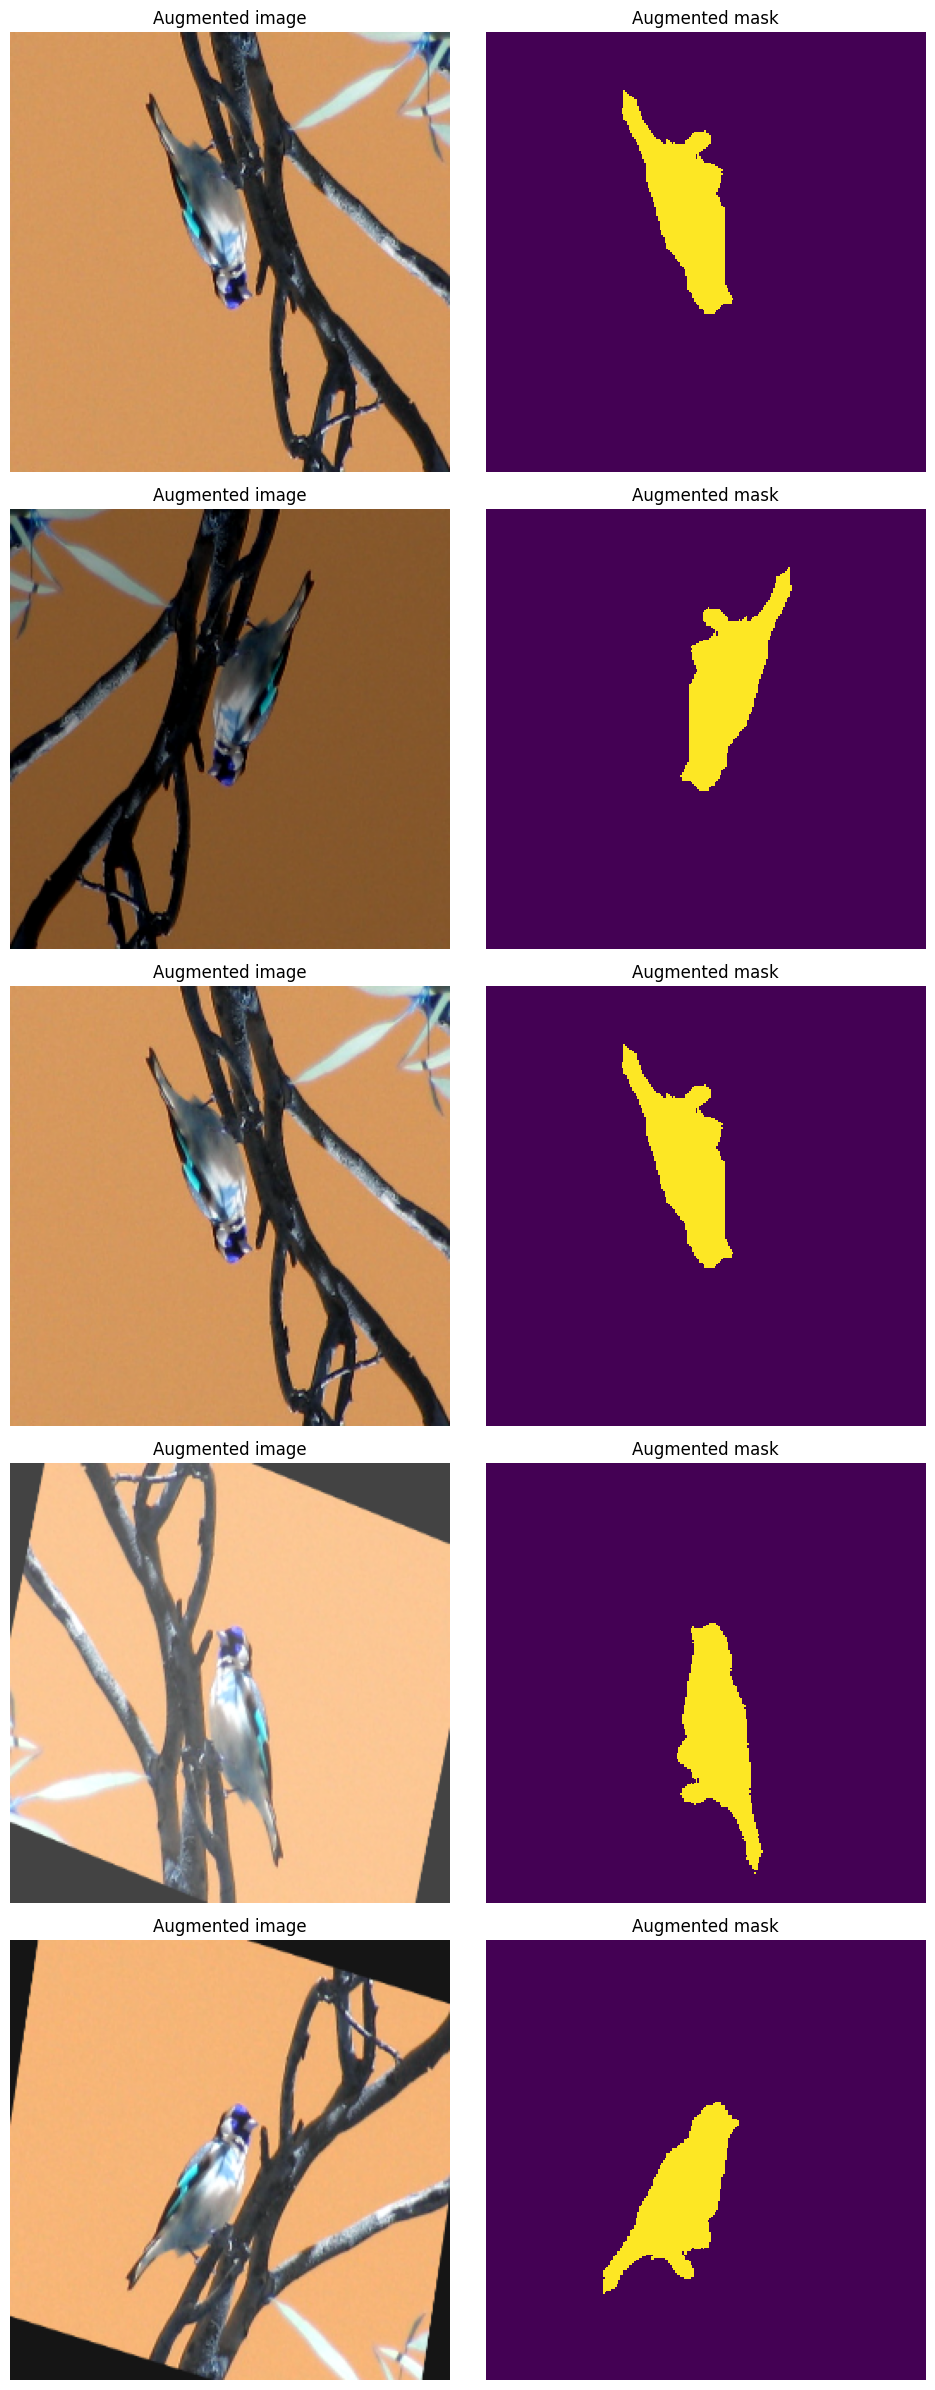

In [112]:
np.random.seed(52)
visualize_augmentations(data, idx=0)

### Architecture (1 point)
Your task for today is to build your own Unet to solve the segmentation problem.

As an encoder, you can use pre-trained on IMAGENET models(or parts) from torchvision. The decoder must be trained from scratch.
It is forbidden to use data not from the `data` folder.

I advise you to experiment with the number of blocks so as not to overfit on the training sample and get good quality on validation.

In [11]:
from torchvision import models

resnet = models.resnet34(pretrained=True)
resnet

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 202MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet34 = torchvision.models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.encoder = nn.ModuleList([
            nn.Sequential(resnet34.conv1, resnet34.bn1, resnet34.relu, resnet34.maxpool),
            resnet34.layer1,
            resnet34.layer2,
            resnet34.layer3,
            resnet34.layer4
        ])

        self.decoder4 = DecoderBlock(256 + 256, 512, 512)
        self.decoder3 = DecoderBlock(512 + 256, 256, 256)
        self.decoder2 = DecoderBlock(256 + 128, 128, 128)
        self.decoder1 = DecoderBlock(128 + 64, 64, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, return_raw=False):
        input_shape = x.shape[-2:]

        x0 = self.encoder[0](x)
        x1 = self.encoder[1](x0)
        x2 = self.encoder[2](x1)
        x3 = self.encoder[3](x2)
        x4 = self.encoder[4](x3)

        d4 = self.decoder4(x4)

        d4_interpolated = F.interpolate(d4, size=x3.shape[-2:], mode='bilinear', align_corners=True)
        d3_input = torch.cat([d4_interpolated, x3], dim=1)
        d3 = self.decoder3(d3_input)

        d3_interpolated = F.interpolate(d3, size=x2.shape[-2:], mode='bilinear', align_corners=True)
        d2_input = torch.cat([d3_interpolated, x2], dim=1)
        d2 = self.decoder2(d2_input)

        d2_interpolated = F.interpolate(d2, size=x1.shape[-2:], mode='bilinear', align_corners=True)
        d1_input = torch.cat([d2_interpolated, x1], dim=1)
        d1 = self.decoder1(d1_input)

        d1_interpolated = F.interpolate(d1, size=input_shape, mode='bilinear', align_corners=True)
        output_mask = self.final_conv(d1_interpolated)

        return output_mask

### Train script (0.5 point)

Complete the train and predict scripts.

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-4):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # YOUR CODE HERE
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

In [14]:
import torch
import gc

def clear_gpu_cache():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU cache cleared.")

clear_gpu_cache()

GPU cache cleared.


In [15]:
def train_segmentation_model(data_path):
    BATCH_SIZE = 32
    N_EPOCH = 15
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_dataset = BirdsDataset(data_path + 'train')
    val_dataset = BirdsDataset(data_path + 'val')
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



    model = Unet().to(DEVICE)
    # for param in model.encoder.parameters():
    #     param.requires_grad = False

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss().to(DEVICE)
    losses_train, losses_val, ious_train, ious_val = [], [], [], []

    train_loss = 0.0
    val_loss = 0.0


    for epoch in range(N_EPOCH):
        model.train()
        train_iou = 0.0
        train_batches = 0
        for inputs, masks in tqdm(train_dataloader, desc=f'Epoch {epoch} Train'):
            inputs = inputs.to(DEVICE)
            masks = masks.to(DEVICE).float()

            output = model(inputs).squeeze(1)
            loss = criterion(output, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds_np = (torch.sigmoid(output.detach()) > 0.5).cpu().numpy()
            masks_np = masks.cpu().numpy()

            batch_iou = 0.0
            for pred, mask in zip(preds_np, masks_np):
                batch_iou += get_iou(mask > 0.5, pred)
            train_iou += batch_iou / len(preds_np)

        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_iou = train_iou / len(train_dataloader)

        losses_train.append(avg_train_loss)
        ious_train.append(avg_train_iou)

        model.eval()
        val_iou = 0.0
        val_batches = 0
        with torch.no_grad():
            for inputs, masks in tqdm(val_dataloader):
                inputs = inputs.to(DEVICE)
                masks = masks.to(DEVICE).float()

                output = model(inputs).squeeze(1)
                loss = criterion(output, masks)

                val_loss += loss.item()


                preds_np = (torch.sigmoid(output).cpu() > 0.5).numpy()
                masks_np = masks.cpu().numpy()

                batch_iou = 0.0
                for pred, mask in zip(preds_np, masks_np):
                    batch_iou += get_iou(mask > 0.5, pred)
                val_iou += batch_iou / len(preds_np)


        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_iou = val_iou / len(val_dataloader)


        losses_val.append(avg_val_loss)
        ious_val.append(avg_val_iou)

        torch.save(model.state_dict(), f'model_{epoch}.pth')

        print(f"Epoch: {epoch}, train loss: {losses_train[-1]:.4f}, val loss: {losses_val[-1]:.4f}, train iou: {ious_train[-1]:.4f}, val iou: {ious_val[-1]:.4f}")

In [103]:
def predict(model, img_path):
    DEVICE = next(model.parameters()).device
    with torch.no_grad():
        img = cv2.imread(img_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = gray2rgb(img)
        original_h, original_w = img.shape[:2]

        transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        transformed = transform(image=img)
        img_tensor = transformed['image']
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        logits = model(img_tensor)
        probs = torch.sigmoid(logits)
        probs = probs.squeeze(0).squeeze(0)
        mask_256 = probs.cpu().numpy()

        segm = cv2.resize(mask_256, (original_w, original_h), interpolation=cv2.INTER_LINEAR)

        return segm

def get_model(path):
    model = Unet().to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [17]:
train_segmentation_model('data/')

100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Epoch: 0, train loss: 0.2382, val loss: 0.1753, train iou: 0.7456, val iou: 0.7918


100%|██████████| 44/44 [00:15<00:00,  2.79it/s]


Epoch: 1, train loss: 0.3926, val loss: 0.3147, train iou: 0.7978, val iou: 0.8036


100%|██████████| 44/44 [00:15<00:00,  2.88it/s]


Epoch: 2, train loss: 0.5149, val loss: 0.4300, train iou: 0.8089, val iou: 0.8079


100%|██████████| 44/44 [00:15<00:00,  2.83it/s]


Epoch: 3, train loss: 0.6207, val loss: 0.5316, train iou: 0.8145, val iou: 0.8169


100%|██████████| 44/44 [00:15<00:00,  2.85it/s]


Epoch: 4, train loss: 0.7181, val loss: 0.6299, train iou: 0.8173, val iou: 0.8083


100%|██████████| 44/44 [00:15<00:00,  2.85it/s]


Epoch: 5, train loss: 0.8080, val loss: 0.7186, train iou: 0.8221, val iou: 0.8221


100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Epoch: 6, train loss: 0.8949, val loss: 0.8037, train iou: 0.8231, val iou: 0.8242


100%|██████████| 44/44 [00:15<00:00,  2.80it/s]


Epoch: 7, train loss: 0.9771, val loss: 0.8878, train iou: 0.8289, val iou: 0.8248


100%|██████████| 44/44 [00:15<00:00,  2.90it/s]


Epoch: 8, train loss: 1.0572, val loss: 0.9690, train iou: 0.8300, val iou: 0.8253


100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Epoch: 9, train loss: 1.1347, val loss: 1.0527, train iou: 0.8333, val iou: 0.8242


100%|██████████| 44/44 [00:15<00:00,  2.83it/s]


Epoch: 10, train loss: 1.2121, val loss: 1.1334, train iou: 0.8324, val iou: 0.8273


100%|██████████| 44/44 [00:15<00:00,  2.90it/s]


Epoch: 11, train loss: 1.2882, val loss: 1.2158, train iou: 0.8344, val iou: 0.8248


100%|██████████| 44/44 [00:15<00:00,  2.86it/s]


Epoch: 12, train loss: 1.3648, val loss: 1.2959, train iou: 0.8333, val iou: 0.8290


100%|██████████| 44/44 [00:15<00:00,  2.87it/s]


Epoch: 13, train loss: 1.4381, val loss: 1.3732, train iou: 0.8379, val iou: 0.8328


100%|██████████| 44/44 [00:15<00:00,  2.87it/s]

Epoch: 14, train loss: 1.5099, val loss: 1.4521, train iou: 0.8401, val iou: 0.8302


You can also experiment with models and write a small report about results. If the report will be meaningful, you will receive an extra point.

### Testing (8 points)
Your model will be tested on the new data, similar to validation, so use techniques to prevent overfitting the model.

* IoU > 0.85 — 8 points
* IoU > 0.80 — 7 points
* IoU > 0.75 — 6 points
* IoU > 0.70 — 5 points
* IoU > 0.60 — 4 points
* IoU > 0.50 — 3 points
* IoU > 0.40 — 2 points
* IoU > 0.30 — 1 points

In [89]:
model = get_model('model_14.pth').to('cuda')

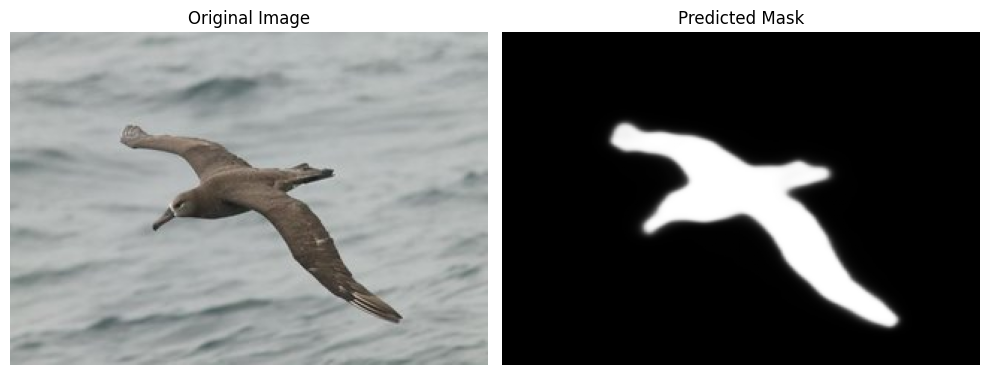

In [113]:
# Example usage of the predict function
# Load a test image
test_image_path = '/content/data/train/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg' # Replace with a path to one of your images

predicted_mask = predict(model, test_image_path)

# Display the original image and the predicted mask
original_image = cv2.imread(test_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

Решил написать код для тестирования модели на всем датасете




In [121]:
transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

ious, times = [], []
test_dataset = BirdsDataset(
    "/content/data/val",
    transform=transform
)

DEVICE = next(model.parameters()).device

for img_path, mask in tqdm(zip(test_dataset.images_paths, test_dataset.gt_paths)):
    t_start = time()
    pred = predict(model, img_path)
    times.append(time() - t_start)

    gt_np = np.asarray(Image.open(mask), dtype = np.uint8)
    if len(gt_np.shape) > 2:
        gt_np = gt_np[:, :, 0]

    mask_binary = (gt_np > 0).astype(bool)
    pred_binary = (pred > 0.5).astype(bool)

    iou = (mask_binary & pred_binary).sum() / (mask_binary | pred_binary).sum()
    ious.append(iou)

test_iou, test_time = np.mean(ious), np.mean(times)
test_iou, test_time

1406it [00:23, 60.12it/s]


(np.float64(0.8244731677465119), np.float64(0.015096369712145875))

### Compression (1 point)

Try to speed up the model in any way without losing more than 1% in iou score.
For example [torch2trt](https://github.com/NVIDIA-AI-IOT/torch2trt)

In [129]:

fast_model = torch.compile(model)


In [130]:
transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

ious, times = [], []
test_dataset = BirdsDataset(
    "/content/data/val",
    transform=transform
)

DEVICE = next(fast_model.parameters()).device

for img_path, mask in tqdm(zip(test_dataset.images_paths, test_dataset.gt_paths)):
    t_start = time()
    pred = predict(fast_model, img_path)
    times.append(time() - t_start)

    gt_np = np.asarray(Image.open(mask), dtype = np.uint8)
    if len(gt_np.shape) > 2:
        gt_np = gt_np[:, :, 0]

    mask_binary = (gt_np > 0).astype(bool)
    pred_binary = (pred > 0.5).astype(bool)

    iou = (mask_binary & pred_binary).sum() / (mask_binary | pred_binary).sum()
    ious.append(iou)

test_iou, test_time = np.mean(ious), np.mean(times)
test_iou, test_time

0it [00:00, ?it/s]W1102 20:01:23.319000 566 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
1406it [00:43, 32.43it/s]


(np.float64(0.8244731841507269), np.float64(0.02951113106007257))

**Bonus:** For the best iou score on test(without compression) in group you will get 1.5, 1, 0.5 extra points(for 1st, 2nd, 3rd places).